<a href="https://colab.research.google.com/github/stephenkiilu/Natural-Language-Processing-NLP-Week_3/blob/main/Stephen_Kiilu_day2_lab_gru_and_transformers_mt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 2: Machine translation using transformers

# Preparation

Make sure you are using a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. 

In [ ]:
! nvidia-smi

Sat Jun  4 11:57:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.4 MB/s 
     |████████████████████████████████| 138 kB 9.1 MB/s 
     |████████████████████████████████| 127 kB 68.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import altair as alt
from collections import Counter, namedtuple
import copy
from itertools import zip_longest
import math
import numpy as np
import os
from os.path import exists
import pandas as pd
import time
import tqdm
import spacy
import sys
import warnings

import torch
from torch import optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torchdata
from torchtext.data.functional import to_map_style_dataset
import torchtext.datasets as datasets
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
RUN_EXAMPLES = True

# Some convenience helper functions used throughout the notebook

def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

# Data

Now we consider a real-world example using the IWSLT 2016 French-English Translation task, consisting of the TED talks parallel scripts. This task is much smaller than the WMT tasks (e.g., https://www.statmt.org/wmt21/translation-task.html), but it illustrates the whole system. 

Data Loading: We will load the dataset using torchtext and spacy for tokenization.

In [ ]:
! gdown 13JgI2SVazCBegGQSR6QeCqf3gwfbOWjp

Downloading...
From: https://drive.google.com/uc?id=13JgI2SVazCBegGQSR6QeCqf3gwfbOWjp
To: /content/2016-01.tgz
100% 188M/188M [00:00<00:00, 251MB/s]


In [ ]:
!mkdir /content/IWSLT2016/
!cp 2016-01.tgz /content/IWSLT2016/

In [ ]:
!python -m spacy download en

In [ ]:
!python -m spacy download fr

In [ ]:
# Load spacy tokenizer models

def load_tokenizers():
    try:
        spacy_de = spacy.load("fr")
    except IOError:
        os.system("python -m spacy download fr")
        spacy_de = spacy.load("fr")

    try:
        spacy_en = spacy.load("en")
    except IOError:
        os.system("python -m spacy download en")
        spacy_en = spacy.load("en")

    return spacy_de, spacy_en

In [ ]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])


def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)
    def tokenize_en(text):
        return tokenize(text, spacy_en)
    print("Building French Vocabulary ...")
    train, val, test = datasets.IWSLT2016(root='/content/', split=('train', 'valid', 'test'), 
                                          language_pair=('fr', 'en'), valid_set='tst2013', test_set='tst2014')
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=7,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )
    print("Building English Vocabulary ...")
    train, val, test = datasets.IWSLT2016(root='/content/', split=('train', 'valid', 'test'), 
                                          language_pair=('fr', 'en'), valid_set='tst2013', test_set='tst2014')
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=7,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )
    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])
    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
    torch.save((vocab_src, vocab_tgt), "vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

In [ ]:
if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

Building French Vocabulary ...
Building English Vocabulary ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Finished.
Vocabulary sizes:
21519
18249


In [ ]:
spacy_de, spacy_en

(<spacy.lang.fr.French at 0x7f8a18bcf250>,
 <spacy.lang.en.English at 0x7f8a18c0fc50>)

Let's explore some of the data examples

In [ ]:
train, val, test = datasets.IWSLT2016(root='/content/', split=('train', 'valid', 'test'), 
                                      language_pair=('fr', 'en'), valid_set='tst2013', test_set='tst2014')

current_sample = iter(train)

for i, (source, reference) in enumerate(train):
    if i > 5:
      break
    print(f'Source: {source}Reference: {reference}\n')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Source: David Gallo: Voici Bill Lange. Je suis Dave Gallo.
Reference: David Gallo: This is Bill Lange. I'm Dave Gallo.


Source: Nous allons vous raconter quelques histoires de la mer en vidéo.
Reference: And we're going to tell you some stories from the sea here in video.


Source: Nous avons des vidéos du Titanic parmi les plus spectaculaires jamais vues. et nous n'allons pas vous en montrer une image.
Reference: We've got some of the most incredible video of Titanic that's ever been seen, and we're not going to show you any of it.


Source: La vérité est que le Titanic -- même s'il continue de battre toutes les records de recettes -- n'est pas l'histoire la plus passionnante.
Reference: The truth of the matter is that the Titanic -- even though it's breaking all sorts of box office records -- it's not the most exciting story from the sea.


Source: Le problème, je crois, est qu'on tient l'océan pour acquis.
Reference: And the problem, I think, is that we take the ocean for granted.


In [ ]:
BOS_IDX = 0
EOS_IDX = 1
PAD_IDX = 2
UNK_IDX = 3

UNK_TOKEN = '<unk>'
EOS_TOKEN = '<eos>'

Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches.

In [ ]:
# Iterators

def collate_batch(
    batch, src_pipeline, tgt_pipeline, src_vocab, tgt_vocab, device,
    max_padding=128, pad_id=2
): 
    bos_id = torch.tensor([BOS_IDX], device=device)  # <s> token id
    eos_id = torch.tensor([EOS_IDX], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat([bos_id,
                                   torch.tensor(
                                       src_vocab(src_pipeline(_src)),
                                       dtype=torch.int64, device=device),
                                   eos_id],
                                  0)
        processed_tgt = torch.cat([bos_id,
                                   torch.tensor(
                                       tgt_vocab(tgt_pipeline(_tgt)),
                                       dtype=torch.int64, device=device),
                                   eos_id],
                                  0)
        src_list.append(
            F.pad(
                processed_src,
                (0, max_padding - len(processed_src)),
                value=pad_id,
            )
        )
        tgt_list.append(
            F.pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

def create_dataloaders(
    device, vocab_src, vocab_tgt, spacy_de, spacy_en, batch_size=12000,
    max_padding=128, is_distributed=False
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.IWSLT2016(
        root='/content/', language_pair=("fr", "en"), split=('train', 'valid', 'test'), valid_set='tst2013', test_set='tst2014'
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )
    test_iter_map = to_map_style_dataset(test_iter)
    test_sampler = (
        DistributedSampler(test_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map, batch_size=batch_size, shuffle=(train_sampler is None),
        sampler=train_sampler, collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map, batch_size=batch_size, shuffle=(valid_sampler is None),
        sampler=valid_sampler, collate_fn=collate_fn,
    )
    test_dataloader = DataLoader(
        test_iter_map, batch_size=batch_size, shuffle=(test_sampler is None),
        sampler=test_sampler, collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader, test_dataloader

In [ ]:
train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    'cuda', vocab_src, vocab_tgt, spacy_de, spacy_en,
    batch_size=64, max_padding=32,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Tokenized data example

In [ ]:
dataloader_dict = {
    'train': train_dataloader, 
    'val': valid_dataloader, 
    'test': test_dataloader
}

for i, (source, reference) in enumerate(dataloader_dict['train']):
    print(f'Source: {source[0].tolist()}\nReference:{reference[0].tolist()}\n\n')
    break

Source: [0, 596, 21, 5767, 16, 340, 7781, 2600, 7, 2222, 17040, 39, 14, 262, 549, 146, 25, 352, 162, 437, 5, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Reference:[0, 34, 4, 19, 493, 7, 9690, 392, 363, 9, 1566, 10119, 132, 7, 196, 275, 103, 14, 381, 154, 332, 6, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2]




# Autoregressive machine translation, on a high level 

### Learning

NMT systems usually model the distribution $p(\mathbf{y} \mid \mathbf{x})$ where $\mathbf{x} = (x_1, x_2, \dots, x_{T_s})$ is a source language sequence and $\mathbf{y} = (y_1, y_2, \dots, y_{T})$ is a target-language sequence. 

Most NMT systems use an autoregressive factorization: $$\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}} \sum_{t=1}^T \log p_\theta (y_t \mid \mathbf{y}_{1:t-1}, \mathbf{x}).$$

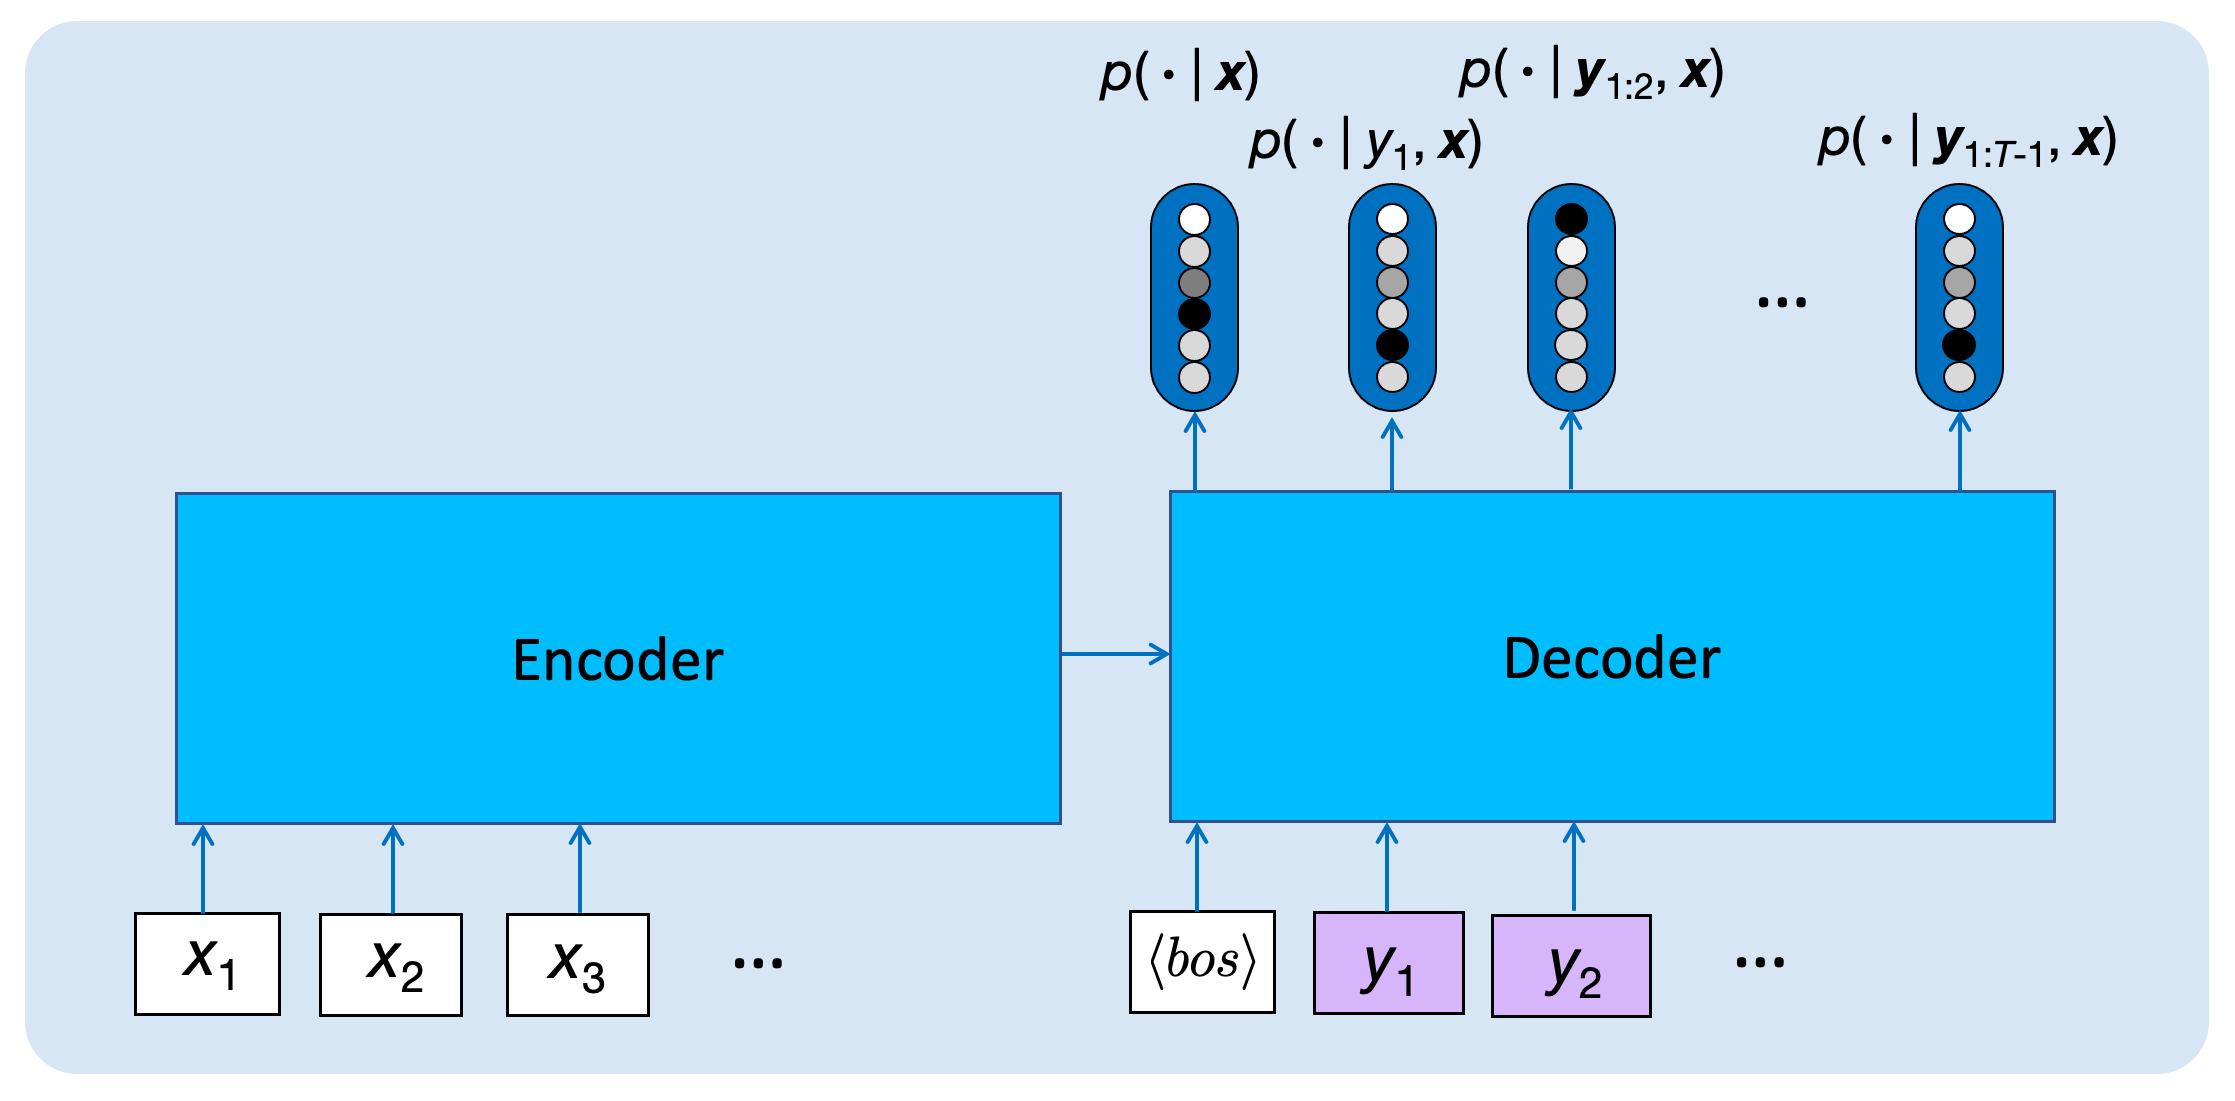

### Inference

We'll discuss specific decoding algorithms tomorrow. 

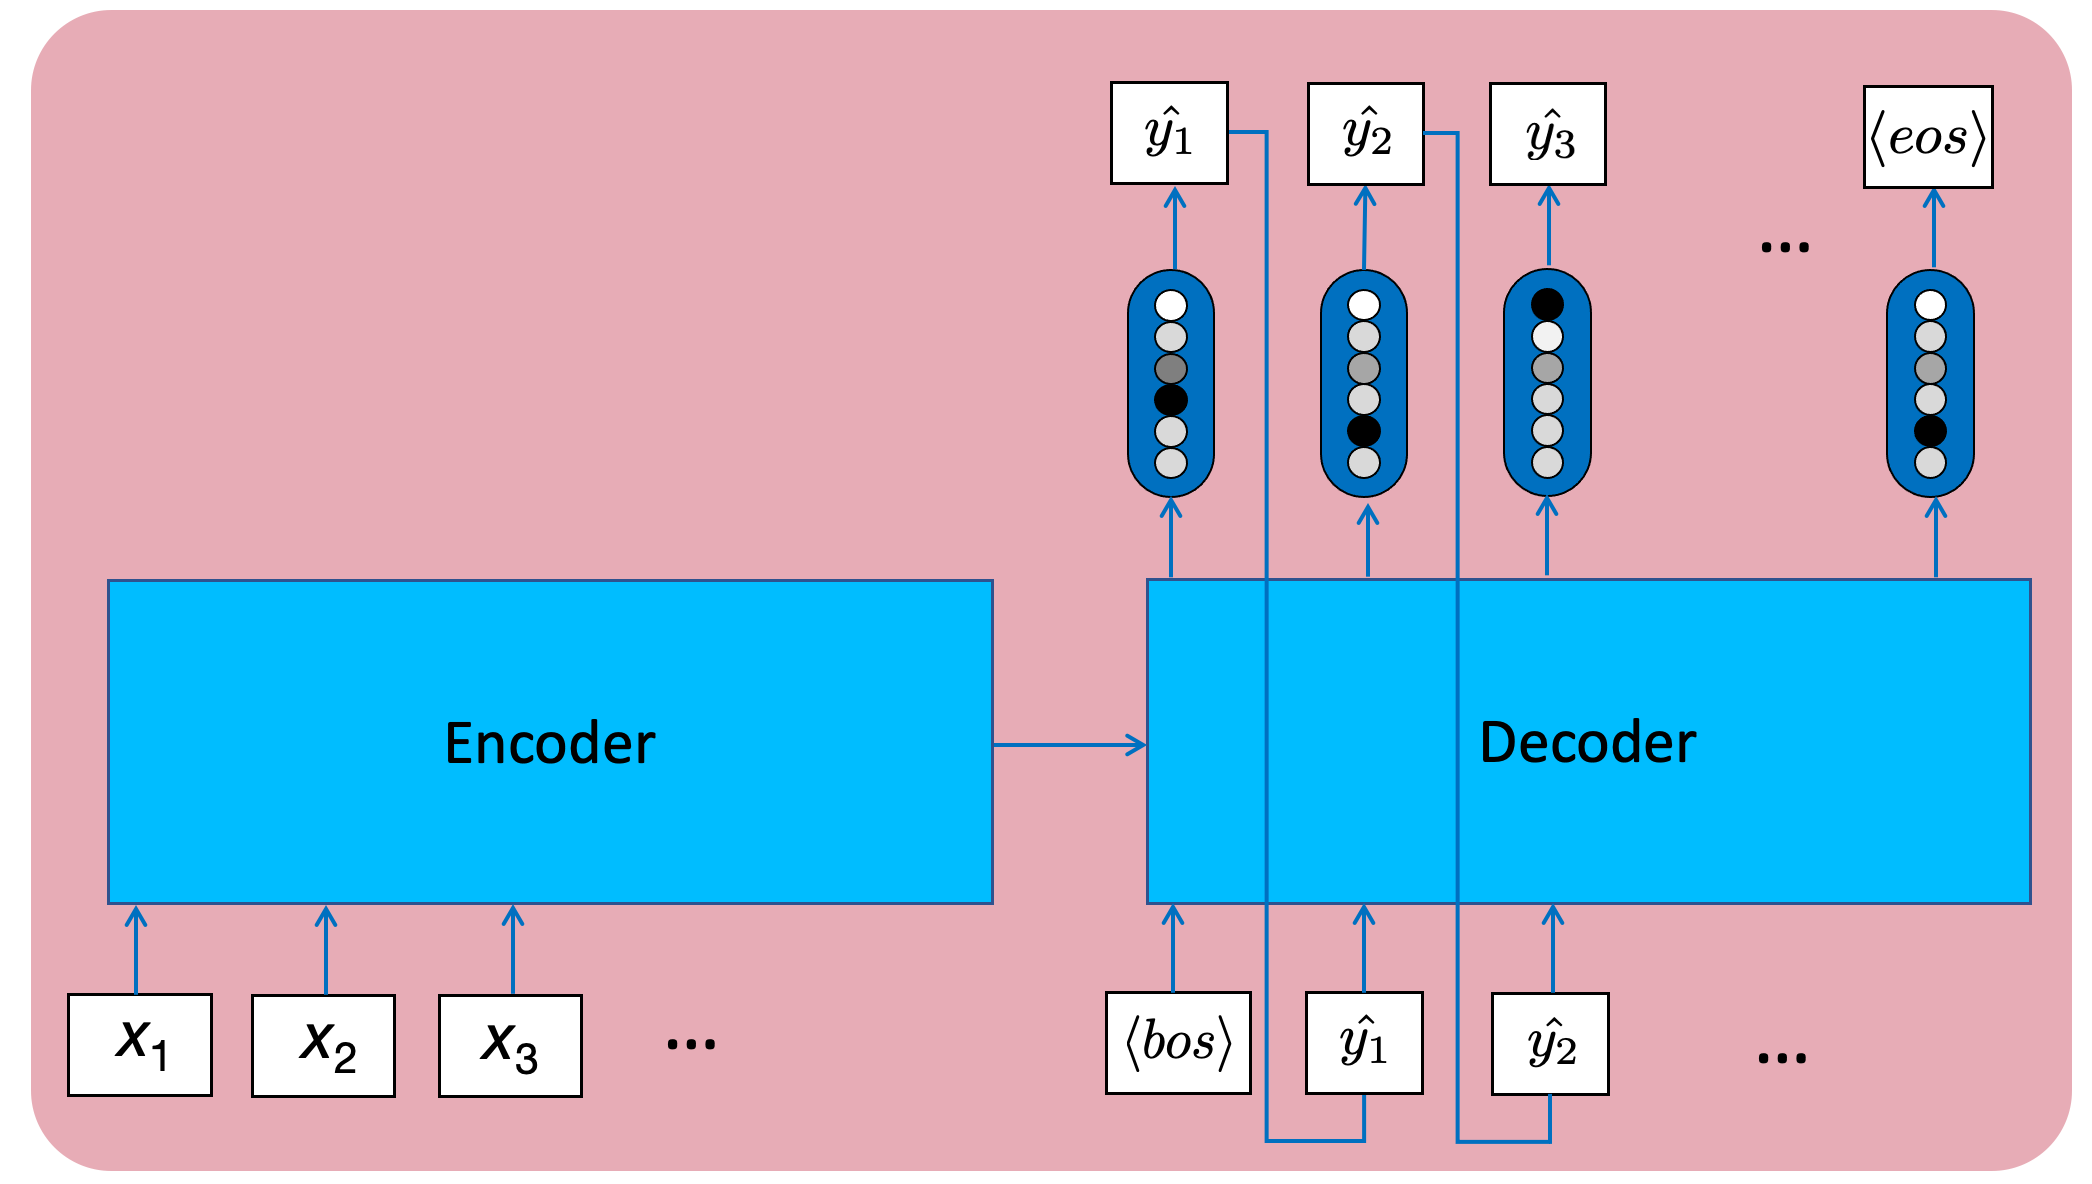

What's "encoder" and what's "decoder" in the above figures? They can be made of any architecture (e.g., RNNs, LSTMs, GRUs, transformers).

On a high level, each encoder consists of many transformer encoder layers. Each decoder consists of many transformer decoder layers. 

# Machine translation using GRUs (as a baseline)

GRU resolves the main problem of RNN: vanishing gradients. Vanishing gradients prevent the network from capturing long-term dependencies. GRU overcomes this problem by introducing shortcut connections. 

While straightforward usage of shortcut connections may result in forward pass issues, GRU alleviates the issue with update and reset gates.

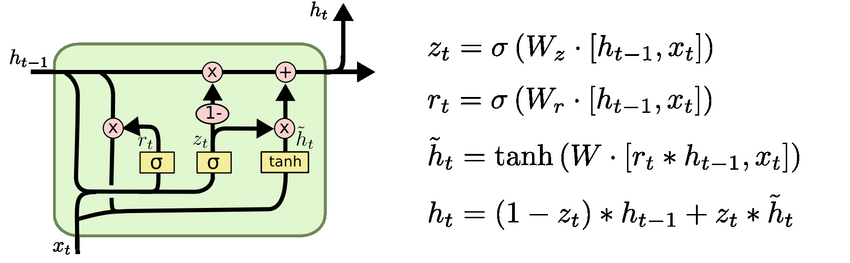

## Architecture

In [ ]:
hidden_size = 512
rnn_layers = 2
longest_label = 32

lr = 0.001
gradient_clip = 0.3
num_epochs = 12

In [ ]:
source_name = 'fr'
target_name = 'en'

saved_models_dir = os.path.join('.', source_name+'2'+target_name)

In [ ]:
class EncoderGRU(nn.Module):
    """Encodes the input context."""

    def __init__(self, input_size, hidden_size, numlayers):
        """Initialize encoder.
         :param input_size: size of embedding
        :param hidden_size: size of GRU hidden layers
        :param numlayers: number of GRU layers
        """
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD_IDX)
        self.gru = nn.GRU(
            hidden_size, hidden_size, num_layers=numlayers, batch_first=True
        )

    def forward(self, input, hidden=None):
        """Return encoded state.
        :param input: (batchsize x seqlen) tensor of token indices.
        :param hidden: optional past hidden state
        """
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

In [ ]:
encoder_rnn = EncoderGRU(len(vocab_src), hidden_size, rnn_layers)

In [ ]:
encoder_rnn

EncoderGRU(
  (embedding): Embedding(21519, 512, padding_idx=2)
  (gru): GRU(512, 512, num_layers=2, batch_first=True)
)

The only difference between GRU-encoder and GRU-decoder is the **output projection** layer: LogSoftmax. GRU-decoder outputs log-probabilities of the next token.

In [ ]:
class DecoderGRU(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, output_size, hidden_size, numlayers):
        """Initialize decoder.
        :param input_size: size of embedding
        :param hidden_size: size of GRU hidden layers
        :param numlayers: number of GRU layers
        """
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(
            hidden_size, hidden_size, num_layers=numlayers, batch_first=True
        )
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden, encoder_output=None, context_vec = None):
        """Return encoded state.
        :param input: batch_size x 1 tensor of token indices.
        :param hidden: past (e.g. encoder) hidden state
        """
        emb = self.embedding(input)
        rel = F.relu(emb)
        output, hidden = self.gru(rel, hidden)
        scores = self.softmax(self.out(output))
        return scores, hidden

In [ ]:
decoder_rnn = DecoderGRU(len(vocab_tgt), hidden_size, rnn_layers)

In [ ]:
decoder_rnn

DecoderGRU(
  (embedding): Embedding(18249, 512)
  (gru): GRU(512, 512, num_layers=2, batch_first=True)
  (out): Linear(in_features=512, out_features=18249, bias=True)
  (softmax): LogSoftmax(dim=2)
)

## BLEU: automatic corpus-level evaluation

https://aclanthology.org/P02-1040.pdf

BLEU is a de-facto standard choice for MT evaluation, but it has some limitations as well.

BLEU allows to use multi-reference evaluation set: every input sentence may have >=1 reference translation.

### Formulation

#### Modified ngram precision

The crux of the algorithm isa modified n-gram precision, which is based on [precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Precision). 

Assuming unigrams for the moment, the modified unigram precision is described as:

One first counts the maximum number of times a word occurs in any single reference translation. Next, one clips the total count of each candidate word by its maximum reference count (in other words, one truncates each word’s count), adds these clipped counts up, and divides by the total (unclipped) number of candidate words.

**Example**:

Candidate: the the the mat the the the.

Ref 1: **The** cat is on **the** **mat**.

Ref 2: There is a cat on **the** **mat**.

Modified unigram precisions (defined for every candidate unigram): 

the: 2/6 = 0.333

mat: 1/1 = 1.

Modified unigram precision can be generalized to ngram:

In case of n=2, there are three unique bigrams in the candidate: the the, the mat, mat the. What is the modified precisions of bigram 'the the'?

#### Modified ngram precision on block of text

As we said before the BLEU is measured on the corpus-level. Having fixed number $N$ of pairs (candidate, references), the aggregated modified precision for ngram order $n$ is computed as: 

$$
p_{\text{n-order}} = \frac{\sum_{n=1}^N\sum_{\text{ngram} \in \text{cand}_n} \text{min}(C_{\text{cand}_n}(\text{ngram}), C_\text{maxref}(\text{ngram}))}{\sum_{n^\prime=1}^N\sum_{\text{ngram} \in \text{cand}_{n^\prime}} C_{\text{cand}_{n^\prime}}(\text{ngram})}
$$

#### Combining modified ngram precisions

Precisions decrease ~exponentially as we increase $n$. Geometric average of the modified precisions is used in order to incorporate the decay:

$$
m = \exp \sum_{{\text{n-order}}=1}^N w_\text{n-order} \log p_\text{n-order}
$$

#### Incorporating the sequence length

Modified ngram precision may assign unreasonably high precision to very short candidates! On the other hand, longer candidates receive lower score via the modified precision itself.

Multiplicative brevity penalty is introduced to address the issue of inflated score with shorter candidates. The idea is to penalize the score if the candidate is shorter than the closest reference translation in terms of length.

Computing penalties per sentence pair would make the penalty of the first one to be the outlier and deviate the total penalty. Instead, we compute penalty by summing together all candidate and closest reference lengths:

$$
BP = \exp (1 - \frac{r}{c}) \quad \text{if} \; c \leq r \; \text{else} \; 1
$$,
where $r,c$ are total effective lengths of all reference and candidate translations.

Finally, the BLEU is computed as:

$$
    \text{BLEU} = BP \cdot m 
$$

And again, **BLEU is a CORPUS-level metric**, as on sentence-level we can not say anything about correlation with human judgements.

Implications of BLEU design:

* More reference translations will increase the score.
* Even professional translators will not necessarily get 1. BLEU. 

In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 7.3 MB/s 


In [ ]:
import sacrebleu

Combined module incorporating training utilities

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(
        self, encoder, decoder, lr=1e-3, use_cuda=True, hiddensize=128, 
        numlayers=2, target_lang_vec2tokens=None, longest_label=20, clip=0.3,
    ):
        super(Seq2Seq, self).__init__()
        device = torch.device(
            "cuda" if (torch.cuda.is_available() and use_cuda) else "cpu"
        )
        self.device = device
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.target_lang_vec2tokens = target_lang_vec2tokens

        # set up the criterion
        self.criterion = nn.NLLLoss()

        self.optims = {
            "nmt": optim.Adam(self.parameters(), lr=lr)
        }

        self.scheduler = {}
        for x in self.optims.keys():
            self.scheduler[x] = ReduceLROnPlateau(
                self.optims[x], mode="max", min_lr=1e-4, patience=0, verbose=True
            )

        self.longest_label = longest_label
        self.hiddensize = hiddensize
        self.numlayers = numlayers
        self.clip = clip
        self.START = torch.LongTensor([BOS_IDX]).to(device)
        self.END_IDX = EOS_IDX

    def zero_grad(self):
        """Zero out optimizer."""
        for optimizer in self.optims.values():
            optimizer.zero_grad()

    def scheduler_step(self, val_bleu):
        for scheduler in self.scheduler.values():
            scheduler.step(val_bleu)

    def v2t(self, vector):
        """Convert vector to text.
        :param vector: tensor of token indices.
            1-d tensors will return a string, 2-d will return a list of strings
        """
        if vector.dim() == 1:
            output_tokens = []
            # Remove the final END_TOKEN that is appended to predictions
            for token in vector:
                if token == self.END_IDX:
                    break
                else:
                    output_tokens.append(token)
            return self.target_lang_vec2tokens(output_tokens)

        elif vector.dim() == 2:
            return [self.v2t(vector[i]) for i in range(vector.size(0))]
        raise RuntimeError(
            "Improper input to v2t with dimensions {}".format(vector.size())
        )

    def get_bleu_score(self, val_loader):
        predicted_list = []
        real_list = []
        for data in val_loader:
            predicted_list += self.eval_step(data)
            real_list += self.v2t(data[1])  # data[1] corresponds to labels
        return sacrebleu.corpus_bleu(predicted_list, [real_list]).score

    def train_step(self, batch):
        """Train model to produce ys given xs.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return estimated responses, with teacher forcing on the input sequence
        (list of strings of length batchsize).
        """
        xs, ys = batch

        if xs is None:
            return
        xs = xs.to(self.device)
        ys = ys.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        loss = 0
        self.zero_grad()  # step 1 of 5
        self.encoder.train()
        self.decoder.train()
        target_length = ys.size(1)
        # save largest seen label for later
        self.longest_label = max(target_length, self.longest_label)

        encoder_output, encoder_hidden = self.encoder(xs)

        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden = self.decoder(
            decoder_input, encoder_hidden, encoder_output)  # step 2 of 5

        scores = decoder_output.view(-1, decoder_output.size(-1))
        loss = self.criterion(scores, ys.view(-1))  # step 3 of 5
        loss.backward()  # step 4 of 5
        if self.clip is not None:
            torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), self.clip)
            torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), self.clip)
        for optimizer in self.optims.values():
            optimizer.step()  # step 5 of 5

        _max_score, predictions = decoder_output.max(2)
        return self.v2t(predictions), loss.item()

    def eval_step(self, batch, return_attn = False):
        """Generate a response to the input tokens.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return predicted responses (list of strings of length batchsize).
        """
        if len(batch) == 2:
          xs, _ = batch
        else:
          xs = batch.text_vecs
        if xs is None:
            return
        xs = xs.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        # just predict
        self.encoder.eval()
        self.decoder.eval()
        encoder_output, encoder_hidden = self.encoder(xs)

        predictions = []
        done = [False for _ in range(bsz)]
        total_done = 0
        decoder_input = starts
        decoder_hidden = encoder_hidden

        context_vec = None
        for i in range(self.longest_label):
            # generate at most longest_label tokens

            decoder_output, decoder_hidden = self.decoder(
                decoder_input, decoder_hidden, encoder_output, context_vec)
            _max_score, preds = decoder_output.max(2)
            predictions.append(preds)
            decoder_input = preds  # set input to next step
            
            # check if we've produced the end token
            for b in range(bsz):
                if not done[b]:
                    # only add more tokens for examples that aren't done
                    if preds[b].item() == self.END_IDX:
                        # if we produced END, we're done
                        done[b] = True
                        total_done += 1
            if total_done == bsz:
                # no need to generate any more
                break
        predictions = torch.cat(predictions, 1)

        return self.v2t(predictions)

In [ ]:
id2token_tgt = vocab_tgt.get_itos()

def vec2tokens_tgt(list_idx):
    word_list = []
    if type(list_idx) == list:
        for i in list_idx:
            if i not in [EOS_IDX, BOS_IDX, PAD_IDX]:
                word_list.append(id2token_tgt[i])
    else:
        for i in list_idx:
            if i.item() not in [EOS_IDX, BOS_IDX, PAD_IDX]:
                word_list.append(id2token_tgt[i.item()])
    return (' ').join(word_list)

In [ ]:
nmt_rnn = Seq2Seq(
    encoder_rnn, decoder_rnn, lr=lr, use_cuda = True, hiddensize = hidden_size,
    numlayers = rnn_layers, target_lang_vec2tokens=vec2tokens_tgt,
    longest_label = longest_label, clip = gradient_clip)

In [ ]:
nmt_rnn

Seq2Seq(
  (encoder): EncoderGRU(
    (embedding): Embedding(21519, 512, padding_idx=2)
    (gru): GRU(512, 512, num_layers=2, batch_first=True)
  )
  (decoder): DecoderGRU(
    (embedding): Embedding(18249, 512)
    (gru): GRU(512, 512, num_layers=2, batch_first=True)
    (out): Linear(in_features=512, out_features=18249, bias=True)
    (softmax): LogSoftmax(dim=2)
  )
  (criterion): NLLLoss()
)

## Training

In [ ]:
def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
        os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))

In [ ]:
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):
    best_bleu = -1
    for epoch in range(num_epochs):
        start = time.time()
        running_loss = 0
        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in tqdm.tqdm_notebook(enumerate(dataloader['train']), total=len(dataloader['train'])): 
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss
            # break  # warning

        epoch_loss = running_loss / len(dataloader['train']) 
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch % val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()
            nmt.scheduler_step(val_bleu_score);
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type);
        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))


In [ ]:
modelname = 'rnn_model'
train_model(dataloader_dict, nmt_rnn, num_epochs=num_epochs,
            saved_model_path = saved_models_dir, enc_type = 'rnn_test')

Epoch: [0/12]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/3444 [00:00<?, ?it/s]

epoch 0 loss = 2.365973955662824, time = 793.0443227291107
validation bleu:  10.639571717017485
Epoch: [1/12]


  0%|          | 0/3444 [00:00<?, ?it/s]

In [ ]:
print(f'BLEU: {nmt_rnn.get_bleu_score(dataloader_dict['val'])}')

BLEU: 24.9852090854


## GRU with attention

In [ ]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="https://www.researchgate.net/profile/Dirk-Johannssen/publication/336284994/figure/fig1/AS:810957458661376@1570358733057/Illustration-of-the-LSTM-with-attention-mechanism-The-LSTM-receives-hidden-states-and.ppm",
      width=500, height=500)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1) # [batch size, src len, dec hid dim]
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch size, src len, enc hid dim * 2]
        
        scores = torch.relu(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch size, src len, dec hid dim]

        attention = self.v(scores).squeeze(2) # [batch size, src len]
        
        return F.softmax(attention, dim=1)

class AttentionDecoderGRU(nn.Module):
    """Generates a sequence of tokens in response to context with self attention.
       Note that this is the same as previous decoder if self_attention=False"""

    def __init__(self, output_size, hidden_size, num_layers):
        super(AttentionDecoderGRU, self).__init__()

        self.output_size = output_size

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)

        self.gru = nn.GRU(hidden_size * 2, hidden_size)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.attention = Attention(self.hidden_size)
            
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        
        print(hidden.shape, encoder_outputs.shape)

        hidden = hidden[0]
        
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1) # [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch size, src len, enc hid dim * 2]        
        weighted = torch.bmm(a, encoder_outputs) # [batch size, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2) # [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim=2) # [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        scores = self.out(output)
        scores = self.softmax(scores)
        
        return scores, hidden.squeeze(0)

## Evaluation

In [ ]:
print(f'BLEU: {nmt_rnn_attention.get_bleu_score(dataloader_dict['test'])}')

BLEU: 30.5890801839843


In [ ]:
token2id_src = vocab_src.get_stoi()

In [ ]:
def vec2tokens_src(sentence):
  token_list = sentence.lower().split()
  index_list = [token2id_src[token] if token in token2id_src else UNK_IDX for token in token_list]
  return torch.from_numpy(np.array(index_list)).to('cuda')

In [ ]:
def get_encoded_batch(sentence, vec2tokens_tgt, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + EOS_TOKEN
    tensor = vec2tokens_tgt(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple(
        tensor.to(device), 
        torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
        None, None, False );

    return return_tuple

In [ ]:
def get_translation(nmt_model, sentence, vec2tokens_src, use_cuda):
    print('source: ', sentence)
    batch = get_encoded_batch(sentence, vec2tokens_src, use_cuda);
    
    prediction = nmt_model.eval_step(batch)
    prediction = prediction[0];
    print('prediction: ', prediction)

In [ ]:
get_translation(
    nmt_rnn, 
    "un homme se tient à côté d'une tente et d'un bateau sur la plage.", 
    vec2tokens_src, 
    use_cuda=True)

source: un homme se tient à côté d'une tente et d'un bateau sur la plage.
prediction:  A person in a tan coat stands at the top of a wooden platform and looks at a bag standing on a pier.


# Machine translation using transformers

This section is largely based on Prof. Sasha Rush's Annotated Transformer (https://nlp.seas.harvard.edu/2018/04/03/attention.html) and its updated version. 

## Part 1: Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure (https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive (https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next.

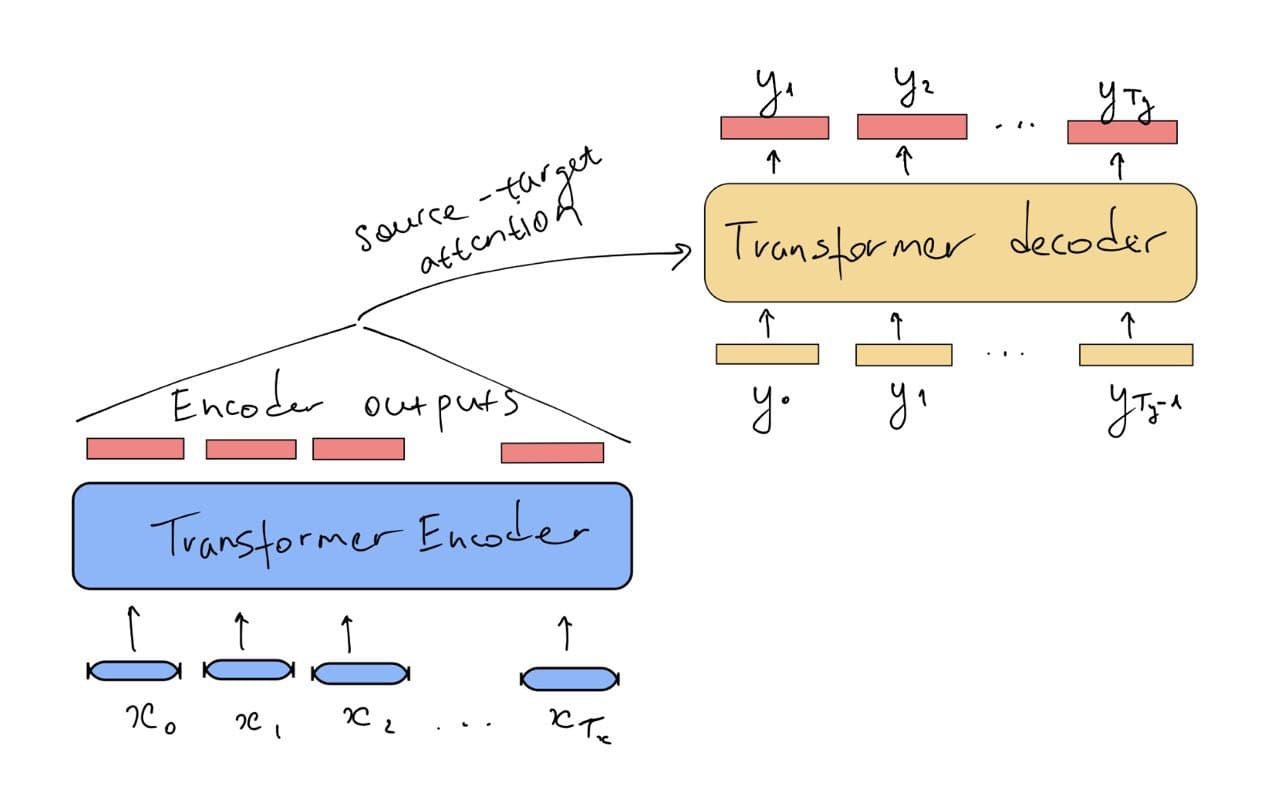

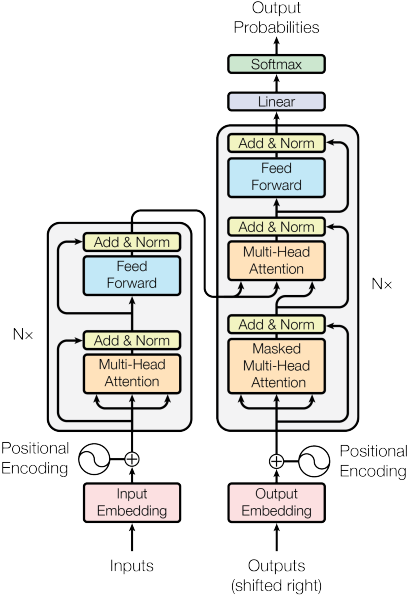

Q: Dimensionality of input $\mathbf{x} = (x_1, \dots, x_T)$ before the embedding steps?

Q: Dimension of the input after the embedding step?

Q: Dimensionality of the output (after the softmax layer; see top-right corner of the picture)?

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard encoder-decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), 
                           src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

```
    # Now you might ask: How do we define a model? 

    position = [to be implemented]  # position embedding
    model = EncoderDecoder(
        [encoder to be implemented],
        [decoder to be implemented],
        nn.Sequential(Embeddings(d_model, src_vocab), position),
        nn.Sequential(Embeddings(d_model, tgt_vocab), position),
        Generator(d_model, tgt_vocab),
    )
```


### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
# To create N copies of a layer
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

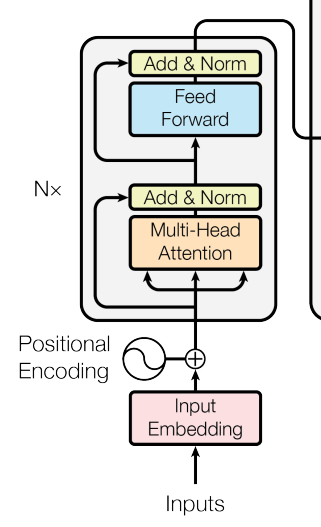

We employ a residual connection (https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization (https://arxiv.org/abs/1607.06450). Aside: There are different forms of layer normalization (https://arxiv.org/pdf/2002.04745.pdf). 

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout (http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn  # will explain later
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections; see https://arxiv.org/pdf/1706.03762.pdf."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        tmp = self.sublayer[1](x, self.feed_forward)
        return tmp

```
    # Updating our model definition:
    
    attn = [to be implemented]
    ff = [to be implemented]
    position = [to be implemented]
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, attn, ff, dropout), N),
        [decoder to be implemented],
        nn.Sequential(Embeddings(d_model, src_vocab), position),
        nn.Sequential(Embeddings(d_model, tgt_vocab), position),
        Generator(d_model, tgt_vocab),
    )
```

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.  

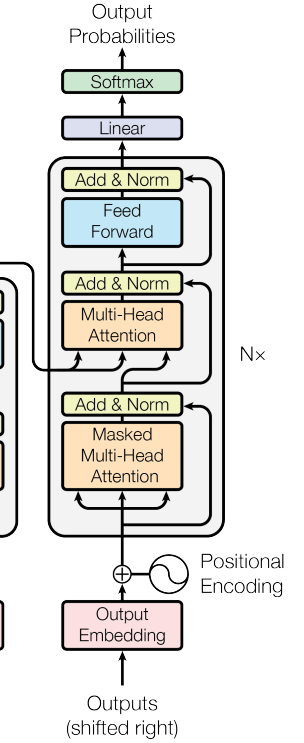

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts **a third sub-layer, which performs multi-head attention over the output of the encoder stack**.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify **the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions**.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

`subsequent_mask(30)` is the following:
```
tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int32)
```

> Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

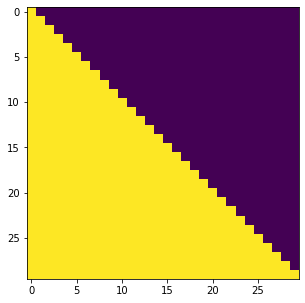

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(30)[0])
None

```
    # Updating our model definition:
    
    attn = [to be implemented]
    ff = [to be implemented]
    position = [to be implemented]
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, attn, ff, dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), position),
        nn.Sequential(Embeddings(d_model, tgt_vocab), position),
        Generator(d_model, tgt_vocab),
    )
```

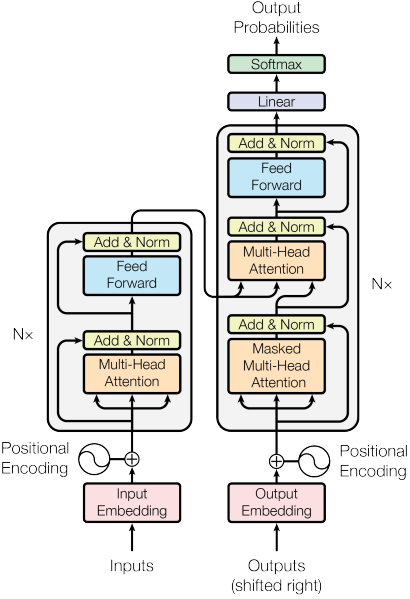

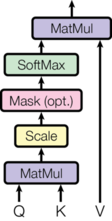

### Attention                                                                                                                                                                                                                                                                             
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a **weighted sum of the values**, where the weight assigned to each value is computed by a **compatibility function of the query with the corresponding key**.                                                                                                                                                                                                                                                                                   

We call our particular attention "Scaled Dot-Product Attention." The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values. Why $\sqrt{d_k}$? See https://kyunghyuncho.me/a-few-qa-from-the-course/#q6.                                                                                                                                                                                          
                                                                                                                                                                     


In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^\top}{\sqrt{d_k}})V
$$
where $Q, K, V \in \mathbb{R}^{T \times d_\text{model}}$.    

Intuition? The quick brown fox jumps over the lazy dog. 

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention (https://arxiv.org/abs/1409.0473), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                               


While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ (https://arxiv.org/abs/1703.03906). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.        

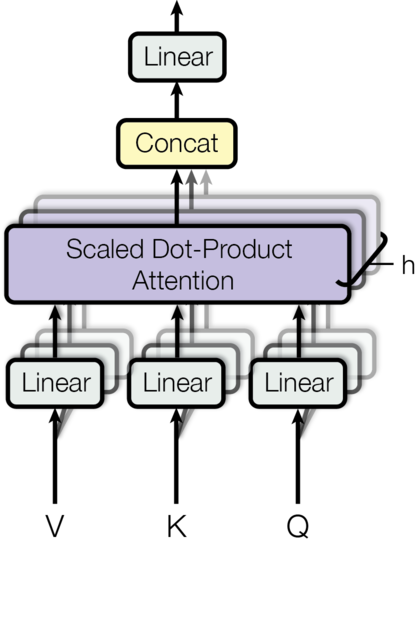

**Multi-head attention** allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                            
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O,
$$
where
$$
\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$
$$
= \mathrm{softmax}\left( \frac{(QW_i^{Q})(KW_i^{K})^\top}{\sqrt{d_k}} \right) VW_i^V. 
$$


Where the projections are parameter matrices $$W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k},$$ $$W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k},$$ $$W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v},$$ $$W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}.$$

In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality. 

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

**Applications of Attention in our Model**

The Transformer uses multi-head attention in three different ways:   

- 1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (https://arxiv.org/abs/1609.08144).    


- 2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   


- 3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                                                                                                                                                      

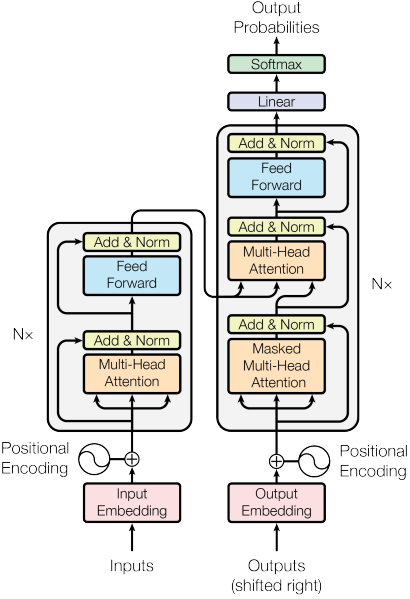

### Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to (https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                 

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

#### Positional Encoding                                                                                                                             

                                                                                                                                                                                                                                                    


Since our model contains no recurrence and no convolution, in order for the model to **make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence**.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  

What properties of the positional embedding function do we want?
- Smooth
- Bounded
- Long sequence without being saturated

Furthermore, we can minimize repetition by using a different scale/offset.
- Chance of repeating positional encoding is minimal

The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed (https://arxiv.org/pdf/1705.03122.pdf). 

In this work, we use sine and cosine functions of different frequencies:

$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                 
            
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized **it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$**. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

> Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension. 

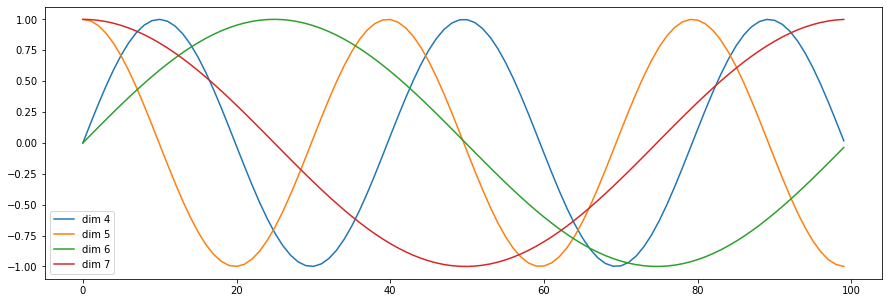

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings (https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

### Full Model

> Here we define a function from hyperparameters to a full model. 

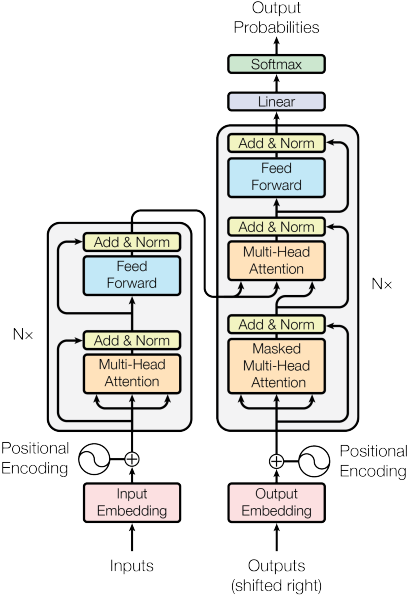

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy   
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### Inference

Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.



In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)  # encode
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[ 0,  6, 10,  1,  3,  6, 10,  1,  3,  6]])
Example Untrained Model Prediction: tensor([[0, 1, 4, 1, 4, 1, 4, 1, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 8, 8, 8, 8, 8, 8, 8, 8, 8]])
Example Untrained Model Prediction: tensor([[0, 3, 2, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[ 0, 10,  0,  7,  7,  7,  7,  7,  7,  7]])
Example Untrained Model Prediction: tensor([[ 0,  5,  0, 10,  1, 10,  1, 10,  1,  0]])
Example Untrained Model Prediction: tensor([[0, 7, 0, 0, 0, 0, 7, 0, 7, 0]])
Example Untrained Model Prediction: tensor([[0, 1, 6, 5, 5, 5, 5, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[0, 9, 0, 9, 0, 9, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[ 0, 10,  0,  2,  8,  8,  8,  8,  8,  8]])


## Part 2: Model training

### Training

This section describes the training regime for our models.

We stop for a quick interlude to introduce some of the tools needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.

In [ ]:
# Batches and masking

class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.



In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed
  
def run_epoch(data_iter, model, loss_compute, optimizer, scheduler,
    mode="train", accum_iter=1, train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state


### Optimizer

We used the Adam optimizer (cite) with $\beta_1=0.9$, $\beta_2=0.98$, and $\epsilon=10^{-9}$. We varied the learning rate over the course of training, according to the formula:

$lrate = d_{\text{model}}^{-0.5} \cdot \min({step\_num}^{-0.5}, {step\_num} \cdot {warmup\_steps}^{-1.5})$

This corresponds to increasing the learning rate linearly for the first warmup\_stepswarmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmup\_steps=4000.

> Note: This part is very important. Need to train with this setup of the model.

> Example of the curves of this model for different model sizes and for optimization hyperparameters.

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

alt.Chart(...)

### Regularization

Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ (https://arxiv.org/abs/1512.00567). This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.

https://kyunghyuncho.me/how-to-think-of-uncertainty-and-calibration-2/

On a high level, there is noise in the measurement, but we don't know the noise -- anything we haven't observed could be answer. Label smoothing can be thought as "reducing the uncertainty arising from the noisy measurement of labels."

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

Here we can see an example of how the mass is distributed to the words based on confidence.

In [ ]:
# Example of label smoothing.

def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )


show_example(example_label_smoothing)


alt.Chart(...)

Label smoothing actually starts to penalize the model if it gets very confident about a given choice.


In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

### Actual training step

In [ ]:
# Training the system

def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    train_worker(0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False)


def load_trained_model():
    config = {
        "batch_size": 64,
        "distributed": False,
        "num_epochs": 16,
        "accum_iter": 8,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "/content/drive/My Drive/teaching/misc/iwslt_model_",  # Note: please replace this path with your own
    }
    model_path = "/content/drive/My Drive/teaching/misc/iwslt_model_final.pt"  # Note: please replace this path with your own
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("/content/drive/My Drive/teaching/misc/iwslt_model_final.pt"))  # Note: please replace this path with your own
    return model

In [ ]:
if is_interactive_notebook():
    model = load_trained_model()

Train worker process using GPU: 0 for training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


[GPU0] Epoch 0 Training ====
Epoch Step:      1 | Accumulation Step:   1 | Loss:   8.55 | Tokens / Sec:  8910.7 | Learning Rate: 5.4e-07
Epoch Step:     41 | Accumulation Step:   6 | Loss:   8.43 | Tokens / Sec: 10784.1 | Learning Rate: 1.1e-05
Epoch Step:     81 | Accumulation Step:  11 | Loss:   8.20 | Tokens / Sec: 10951.8 | Learning Rate: 2.2e-05
Epoch Step:    121 | Accumulation Step:  16 | Loss:   8.01 | Tokens / Sec: 10843.8 | Learning Rate: 3.3e-05
Epoch Step:    161 | Accumulation Step:  21 | Loss:   7.85 | Tokens / Sec: 10756.8 | Learning Rate: 4.4e-05
Epoch Step:    201 | Accumulation Step:  26 | Loss:   7.71 | Tokens / Sec: 10713.2 | Learning Rate: 5.4e-05
Epoch Step:    241 | Accumulation Step:  31 | Loss:   7.52 | Tokens / Sec: 10795.2 | Learning Rate: 6.5e-05
Epoch Step:    281 | Accumulation Step:  36 | Loss:   7.32 | Tokens / Sec: 10651.8 | Learning Rate: 7.6e-05
Epoch Step:    321 | Accumulation Step:  41 | Loss:   7.12 | Tokens / Sec: 10893.3 | Learning Rate: 8.7e-05

Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate.



## Results

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big) in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0 BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model surpasses all previously published models and ensembles, at a fraction of the training cost of any of the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0, outperforming all of the previously published single models, at less than 1/4 the training cost of the previous state-of-the-art model. The Transformer (big) model trained for English-to-French used dropout rate Pdrop = 0.1, instead of 0.3.


With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation.



Note: The `iwslt_model_final.pt` file is in `models/iwslt16-fren/` in our shared folder. So, please duplicate the file to a directory of your choice, and replace `/content/drive/My Drive/teaching/misc/iwslt_model_final.pt` with your own path. 

In [ ]:
def check_outputs(
    set_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2, 
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(set_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        # greedy_decode(model.cuda(), rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model.cuda(), rb.src.cuda(), rb.src_mask.cuda(), 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, _, test_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("/content/drive/My Drive/teaching/misc/iwslt_model_final.pt", map_location=torch.device("cpu"))
    )  # Note: please replace this path with your own

    print("Checking Model Outputs:")
    example_data = check_outputs(
        test_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


out = run_model_example(9)

Preparing Data ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> C' était avant le 11 septembre , et avant que les politiciens ne se mettent à penser qu' il était bon d' avoir comme slogan de campagne « Je déteste les musulmans » .  </s>
Target Text (Ground Truth) : <s> This was before 9/11 and before politicians thought it was appropriate to use " I hate <unk> " as a campaign slogan .  </s>
Model Output               : <s> It was before September 11th , and before politicians start thinking that he was good to have as a campaign slogan of " I hate Muslims . "  </s>

Example 1 ========

Source Text (Input)        : <s> Une année se passe et toujours rien .  </s>
Target Text (Ground Truth) : <s> Maybe a year passes , nothing .  </s>
Model Output               : <s> One year goes on and always nothing .  </s>

Example 2 ========

Source Text (Input)        : <s> Et puis , il y a la stigmatisation .  </s>
Target Text (Ground Truth) : <s> And then the

In [ ]:
def get_bleu_score(predicted_list, ref_list):
    return sacrebleu.corpus_bleu(predicted_list, [ref_list])[0]

In [ ]:
# Assuming we use batch size 1 to run the above inference step on the entire
# development set
cands = []
refs = []
for x in out[1]:
    cands.append(x[-1].replace('<s> ', '').replace(' </s>', ''))
    refs.append(' '.join(x[2]).replace('<s> ', '').replace(' </s>', ''))

In [ ]:
get_bleu_score(cands, refs)

35.53851526396388


## To improve performance: BPE

BPE / Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich's subword-nmt implementation. These models will transform the training data to look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .



Blog post: https://leimao.github.io/blog/Byte-Pair-Encoding/

## Attention visualization

Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention

In [ ]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

### Encoder self attention


In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

Preparing Data ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Quand on est jaloux , on se raconte des histoires .  </s>
Target Text (Ground Truth) : <s> When we feel jealous , we tell ourselves a story .  </s>
Model Output               : <s> When you 're jealous , you tell stories .  </s>


alt.HConcatChart(...)

### Decoder self attention

In [ ]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

Preparing Data ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> La jalousie aime les photos .  </s>
Target Text (Ground Truth) : <s> Jealousy likes photos .  </s>
Model Output               : <s> <unk> love pictures .  </s>


alt.HConcatChart(...)

### Decoder Src Attention


In [ ]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)


Preparing Data ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> La crise de la quarantaine <unk> ne consiste pas à acheter une voiture de sport rouge .  </s>
Target Text (Ground Truth) : <s> The post - millennial <unk> crisis is n't buying a red sports car .  </s>
Model Output               : <s> The <unk> <unk> crisis is not to buy a red - sport car .  </s>


alt.HConcatChart(...)

# Fairseq!